In [30]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

class WalkingTrot():
    """
  trotting gait
  @author: HonboZhu, BoxiXia
  """
    def __init__(self,
                 phase_offset=0,
                 stance_ratio=0.6,
                 stance_start_angle=np.pi / 4,
                 stance_end_angle=3 * np.pi / 4):
        assert (stance_end_angle > stance_start_angle)
        self.phase_offset = phase_offset
        self.stance_ratio = stance_ratio
        self.stance_start_angle = stance_start_angle
        self.stance_end_angle = stance_end_angle
        
        
        self.contact_angle = self.stance_end_angle - self.stance_start_angle
        


    def GetPos(self, phase):
        """
    return the position [0,2pi] given the current phase
    """
        
        vel_air = (2 * np.pi - self.contact_angle) / (1 - self.stance_ratio)
        vel_stance = self.contact_angle / self.stance_ratio # ground contact velocity (normalized)
        
        phase = phase%1.0
        if (phase < 0):
            phase += 1

        if (phase >= 0 and phase < self.stance_start_angle / vel_air):
            desire_angle = vel_air * phase

        elif (phase >= self.stance_start_angle / vel_air and
              phase < self.stance_start_angle / vel_air + self.stance_ratio):
            desire_angle = self.stance_start_angle + vel_stance * (
                phase - self.stance_start_angle / vel_air)

        else:
            desire_angle = vel_air * phase + 2 * np.pi - vel_air
        return desire_angle
    
    def GetVel(self,phase): 
        vel_air = (2 * np.pi - self.contact_angle) / (1 - self.stance_ratio)
        vel_stance = self.contact_angle / self.stance_ratio
        phase = phase%1.0
        if (phase < 0):
            phase += 1
            
        if (phase >= 0 and phase < self.stance_start_angle / vel_air):
            vel = vel_air

        elif (phase >= self.stance_start_angle / vel_air and
              phase < self.stance_start_angle / vel_air + self.stance_ratio):
            vel = vel_stance

        else:
            vel = vel_air
        return vel
    
trot = WalkingTrot()
phase_arr = np.linspace(0,1,1000)
angle1 = np.array([trot.GetPos(phase) for phase in phase_arr])
angle2 = np.array([trot.GetPos(phase+0.5) for phase in phase_arr])
angle3 = 2*np.pi-angle1
angle4 = 2*np.pi-angle2
motor_pos = np.stack((angle1,angle2,angle3,angle4),axis=1)

vel1 = np.array([trot.GetVel(phase) for phase in phase_arr])
vel2 = np.array([trot.GetVel(phase+0.5) for phase in phase_arr])
vel3= -vel1
vel4= -vel2
motor_vel = np.stack((vel1,vel2,vel3,vel4),axis=1)

##If moving forward:

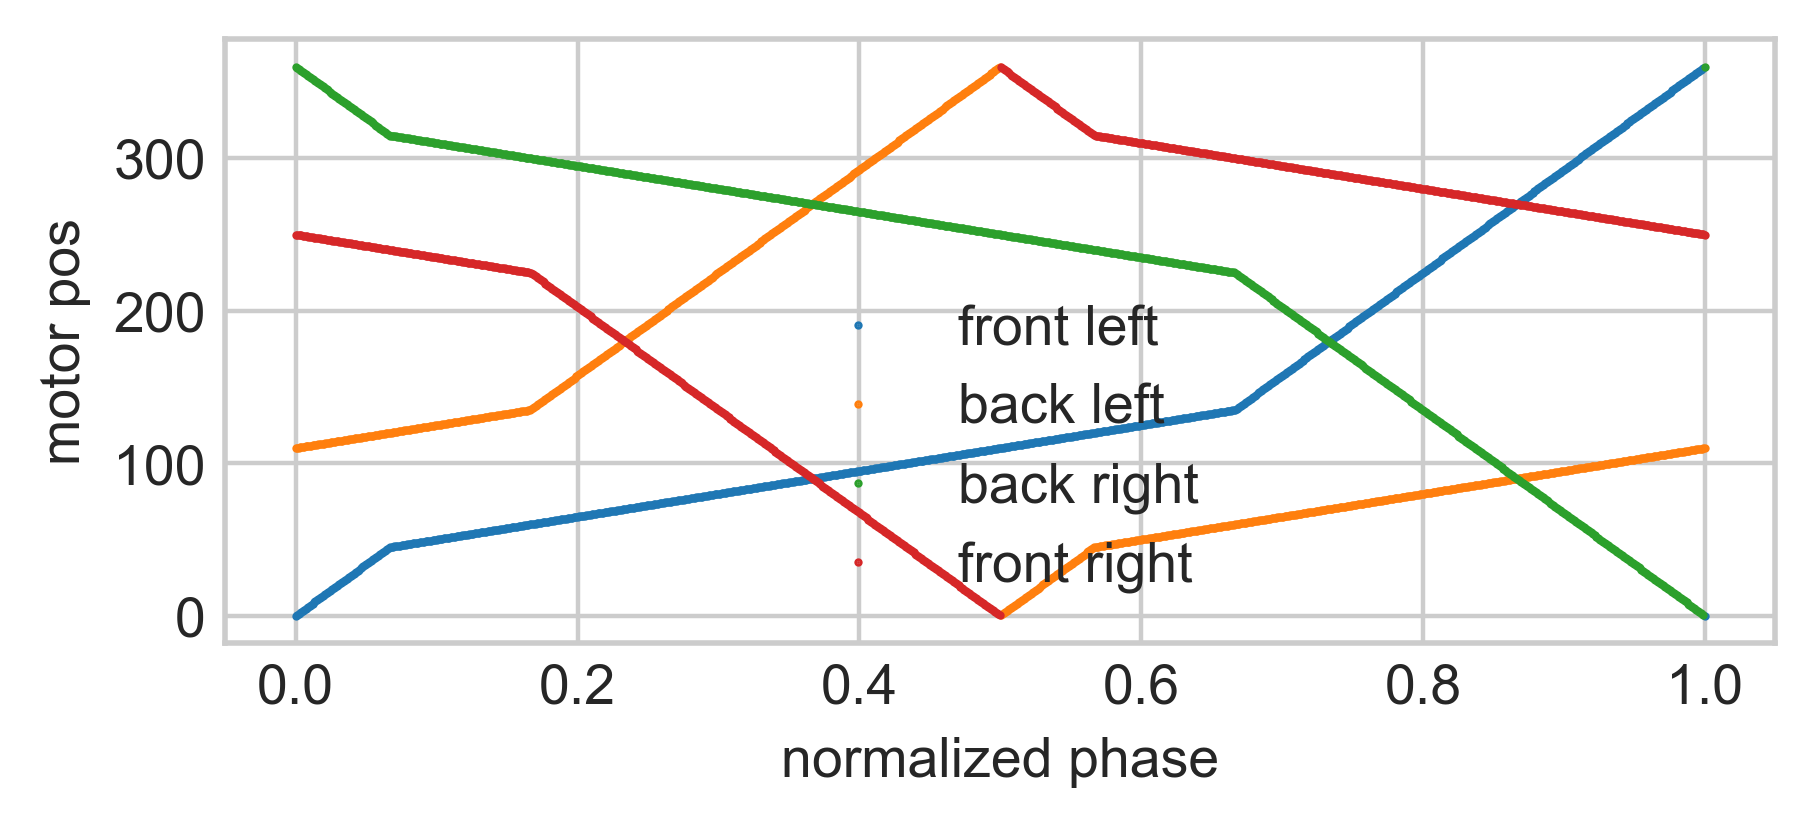

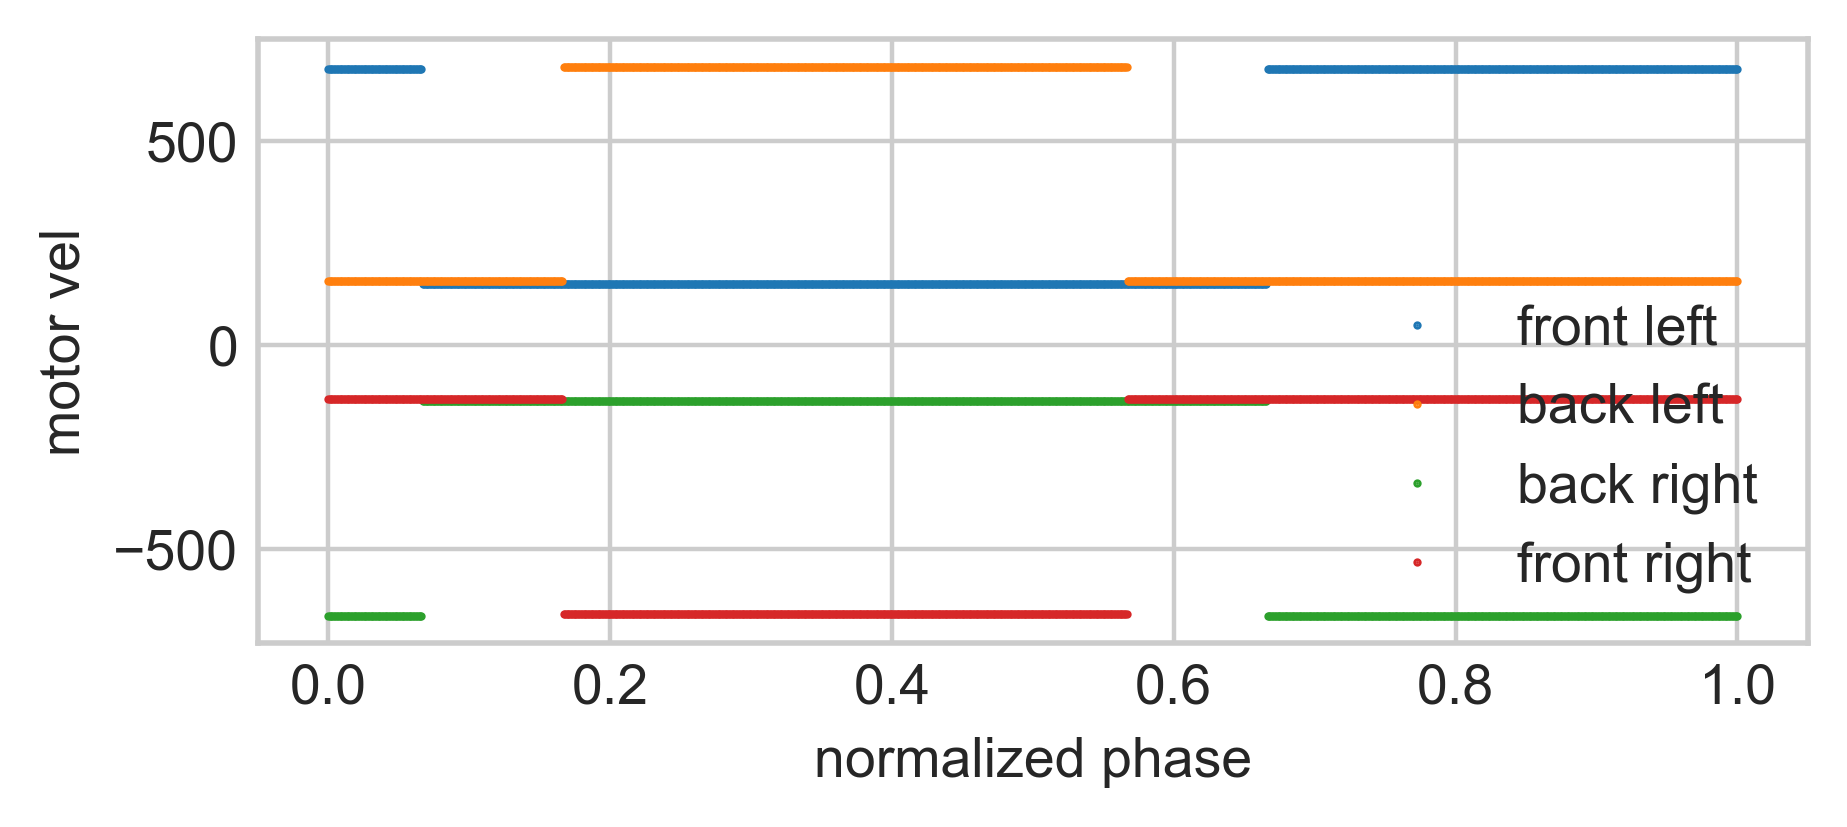

In [29]:
plt.figure(figsize=(5,2),dpi=200)
plt.plot(phase_arr,np.rad2deg(angle1),'.',label='front left',markersize=1)
plt.plot(phase_arr,np.rad2deg(angle2),'.',label='back left',markersize=1)
plt.plot(phase_arr,np.rad2deg(angle3),'.',label='back right',markersize=1)
plt.plot(phase_arr,np.rad2deg(angle4),'.',label='front right',markersize=1)
plt.ylabel("motor pos")
plt.xlabel("normalized phase")
plt.legend()
plt.show()
plt.figure(figsize=(5,2),dpi=200)
plt.plot(phase_arr,np.rad2deg(vel1),'.',label='front left',markersize=1)
plt.plot(phase_arr,np.rad2deg(vel2+0.1),'.',label='back left',markersize=1)
plt.plot(phase_arr,np.rad2deg(vel3+0.2),'.',label='back right',markersize=1)
plt.plot(phase_arr,np.rad2deg(vel4+0.3),'.',label='front right',markersize=1)
plt.ylabel("motor vel")
plt.xlabel("normalized phase")
plt.legend()
plt.show()

In [2]:
from numba import njit

225.0 270.0 315.0
225.0 270.0 315.0
225.0 270.0 315.0
225.0 270.0 315.0


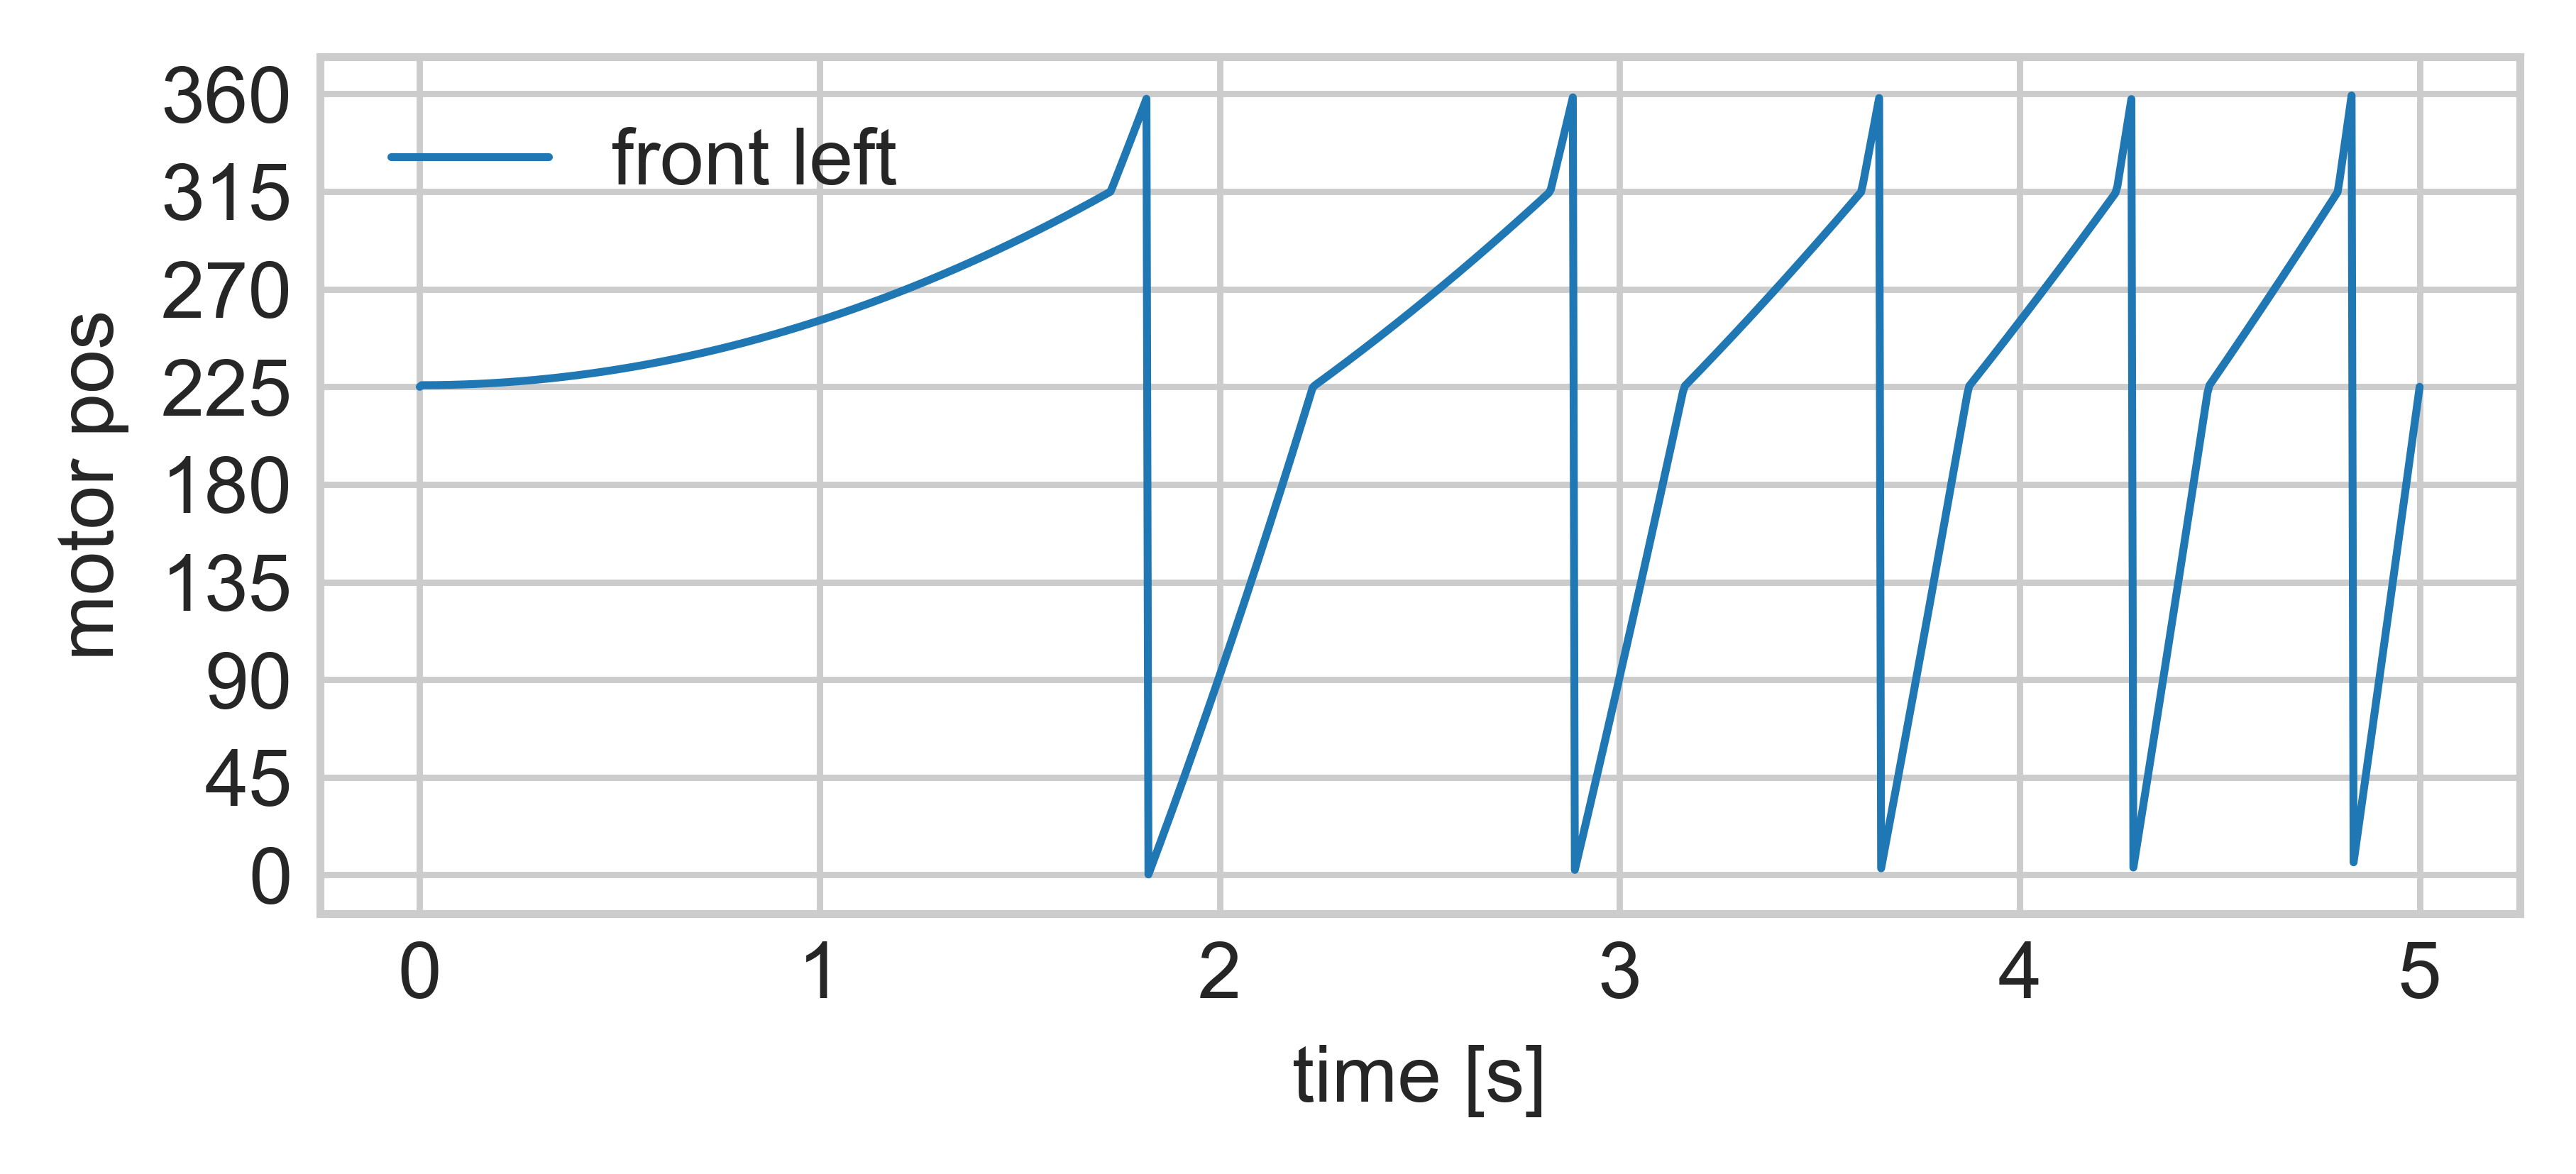

In [134]:
import numpy as np
import matplotlib.pyplot as plt


plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'


PI = np.pi
TWO_PI = 2*np.pi

class WalkingTrot():
    """
  trotting gait
  @author: HonboZhu, BoxiXia
  """
    def __init__(this,
                 ot = 0, # normalized time offset [0-1], [unitless]
                 w = 2*np.pi, # average angular velocity [rad/s]
                 s = 0.6, # stance ratio = stance_time/cycle_time [unitless]
                 contact_angle = 0.5*PI, # contact_angle [rad]
                 p_stance_mid = 3./2.*np.pi,# angle at the middle of the stance phase [rad]
                ):
        this.ot = ot # normalized time offset [0-1], [unitless]
        assert(0<=this.ot<=1)
        this.w = abs(w) # average angular velocity [rad/s]
        this.dir = np.sign(w) # direction of the angular velocity
        this.T = 2*np.pi/this.w # cycle time
        this.c = contact_angle # contact_angle [rad]
#         this.contact_angle
        this.p_stance_mid = p_stance_mid       
        this.p_stance_low = p_stance_mid - this.c/2.0
        
        this.UpdateStanceRatio(s)
#         this.p_stance_low =0
        
        this.p_stance_high = p_stance_mid + this.c/2.0
        print(np.rad2deg(this.p_stance_low),np.rad2deg(p_stance_mid),np.rad2deg(this.p_stance_high))
        
        # get the initial position
        if this.ot<this.s: # if normalized time offset < stance ratio
            this.pos = this.p_stance_low + this.c/this.s*this.ot
        else:
            this.pos = this.p_stance_low + this.c + (TWO_PI-this.c)/(1-this.s)*(this.ot-this.s)
        
#     @njit
    def UpdateStanceRatio(this,s):
        """
        update the stance ratio s (=: stance_time/cycle_time [unitless])
        """
        this.s = s # stance ratio = stance_time/cycle_time [unitless]
        this.ts = this.s * this.T # stance_time
        this.ws = this.c/(this.ts) # w_stance, average angular velocity of stance phase [rad/s]
        this.wa = (TWO_PI-this.c)/((1-this.s)*this.T) # w_air, average angular velocity of air phase [rad/s]
    

    def GetPos(this, t,w=None):
        """
        return the position [0,2pi] [rad] given the current time [s]
        """
        if w==0:
            return this.pos
        if w!=this.w:
            this.UpdateAngularVelocity(t,w)
            
        tc = (t+this.ot*this.T)%this.T # converted time [0-T,seconds]
        
        # todo sign
        if tc<this.ts: # 0-stance_time
            this.pos = (this.p_stance_low + this.ws*tc)%TWO_PI
        else:
            this.pos = (this.p_stance_low + this.c+this.wa*(tc-this.ts))%TWO_PI
        return this.pos

    def UpdateAngularVelocity(this,t,w):
        T2 = 2*np.pi/w # new cycle time
#         print(w)
        tn1 = (t+this.ot*this.T)%this.T/this.T
        this.ot = (tn1 +1 - (t%T2)/T2)%1.0
        this.T = T2
        this.w = w # TODO direction
        
        this.ts = this.s * this.T # stance_time
        this.ws = this.c/(this.ts) # w_stance, average angular velocity of stance phase [rad/s]
        this.wa = (TWO_PI-this.c)/((1-this.s)*this.T) # w_air, average angular velocity of air phase [rad/s] 
#         print(this.ws,this.wa)
#         tn2 = (t+this.ot*this.T)%this.T/this.T
#         print(tn1,tn1-tn2)

    
gaits = [
    WalkingTrot(0),
    WalkingTrot(0.25),
    WalkingTrot(0.5),
    WalkingTrot(0.75)
]

t_arr = np.linspace(0,5,1000)
# w_arr = 2*PI*np.ones_like(t_arr)
# w_arr[80:] = 5*PI

w_arr = np.linspace(0,2*TWO_PI,1000)

angle1 = np.array([gaits[0].GetPos(t,w) for t,w in zip(t_arr,w_arr)])
# angle2 = np.array([gaits[1].GetPos(t,w) for t,w in zip(t_arr,w_arr)])
# angle3 = np.array([gaits[2].GetPos(t,w) for t,w in zip(t_arr,w_arr)])
# angle4 = np.array([gaits[3].GetPos(t,w) for t,w in zip(t_arr,w_arr)])

# angle3 = 2*np.pi-angle1
# angle4 = 2*np.pi-angle2
# motor_pos = np.stack((angle1,angle2,angle3,angle4),axis=1)

# vel1 = np.array([trot.GetVel(phase) for phase in t_arr])
# vel2 = np.array([trot.GetVel(phase+0.5) for phase in t_arr])
# vel3= -vel1
# vel4= -vel2
# motor_vel = np.stack((vel1,vel2,vel3,vel4),axis=1)

plt.figure(figsize=(5,2),dpi=400)
plt.plot(t_arr,np.rad2deg(angle1),',-',markersize=1,linewidth=1,label='front left')
# plt.plot(t_arr,np.rad2deg(angle2),',-',markersize=1,linewidth=1,label='back left')
# plt.plot(t_arr,np.rad2deg(angle3),',-',markersize=1,linewidth=1,label='back right')
# plt.plot(t_arr,np.rad2deg(angle4),',-',markersize=1,linewidth=1,label='front right')

plt.yticks(np.arange(0, 360+45, 45))

plt.ylabel("motor pos")
plt.xlabel("time [s]")
plt.legend()
plt.show()

In [88]:
np.arange(0, 360+45, 45)

array([  0,  45,  90, 135, 180, 225, 270, 315, 360])

In [108]:
None!=1

True

In [25]:
t = np.empty_like(1.)
t[t<1]

array([], dtype=float64)

In [18]:
trot = WalkingTrot()
t = 2.5
trot.GetPos(t)
t

2.5

In [30]:
type(t) != np.ndarray

False